In [1]:
import csv
import math
import networkx as net
from networkx.algorithms import bipartite as bi
import matplotlib as plot
import matplotlib.pyplot as plt
import pandas as pd
import re

In [2]:
# load data in from csv to pandas dataframe
nba_data = csv.reader(open("NBA_network.csv"))

In [6]:
nba_df = pd.read_csv("NBA_network.csv", sep='\s*,\s*', header=None, encoding='ascii', engine='python')

In [8]:
nba_df.iloc[:7, ]

,0,1,2,3,4
0,Blazers2018,Damian Lillard,2018,Blazers,Player
1,Blazers2018,CJ McCollum,2018,Blazers,Player
2,Blazers2018,Jusuf Nurkic,2018,Blazers,Player
3,Blazers2018,Al-Farouq Aminu,2018,Blazers,Player
4,Blazers2018,Seth Curry,2018,Blazers,Player
5,Blazers2018,Maurice Harkless,2018,Blazers,Player
6,Blazers2018,Jake Layman,2018,Blazers,Player


In [9]:
nba_df = nba_df.drop([4], axis=1)

In [10]:
nba_df = nba_df.rename({0:'team_year', 1:'player', 2:'year', 3:'team'}, axis='columns')

In [11]:
nba_df.iloc[:7, ]

,team_year,player,year,team
0,Blazers2018,Damian Lillard,2018,Blazers
1,Blazers2018,CJ McCollum,2018,Blazers
2,Blazers2018,Jusuf Nurkic,2018,Blazers
3,Blazers2018,Al-Farouq Aminu,2018,Blazers
4,Blazers2018,Seth Curry,2018,Blazers
5,Blazers2018,Maurice Harkless,2018,Blazers
6,Blazers2018,Jake Layman,2018,Blazers


In [12]:
nba_df.groupby(['team']).count()

,team_year,player,year
team,,,
Blazers,94,94,94
Bobcats,16,16,16
Bucks,85,85,85
Bulls,94,94,94
Cavaliers,75,75,75
Celtics,79,79,79
Clippers,80,80,80
Grizzlies,88,88,88
Hawks,103,103,103


From the above counts, we see "Bobcats" count as 16 only, which is justified as Bobcats were renamed to Hornets, so we will change Bobcats to Hornets.

In [16]:
teams = list(set(nba_df.loc[:, 'team_year']))

In [17]:
len(teams)

298

In [18]:
players = list(set(nba_df.loc[:, 'player']))

In [19]:
len(players)

529

In [20]:
# create network 
g = net.Graph()

In [22]:
# construct directed graph
for index, row in nba_df.iterrows():
    #if row[0] not in teams:
    #    teams.append(row[0])
    #if row[1] not in players:
    #    players.append(row[1])
    g.add_edge(row['team_year'], row['player'], weight=1)

In [23]:
# find the size of the network (number of nodes)
print("nodes in network:", len(g))

nodes in network: 827


In [24]:
g.number_of_nodes()

827

In [25]:
g.number_of_edges()

2455

In [26]:
bi.is_bipartite(g)

True

In [27]:
# look at components of the whole network
connected_net = list(net.connected_component_subgraphs(g))
print("size of largest component:", len(connected_net[0]))

size of largest component: 827


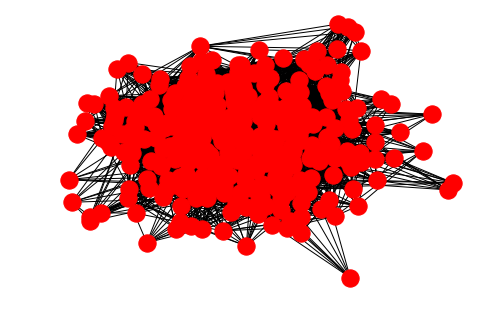

In [29]:
# create an affiliation network of only teams
teamnet = bi.weighted_projected_graph(g, teams)
net.draw(teamnet)

In [30]:
teamnet.number_of_edges()

4860

In [31]:
team_weights = [edata['weight'] for f, t, edata in teamnet.edges(data=True)]

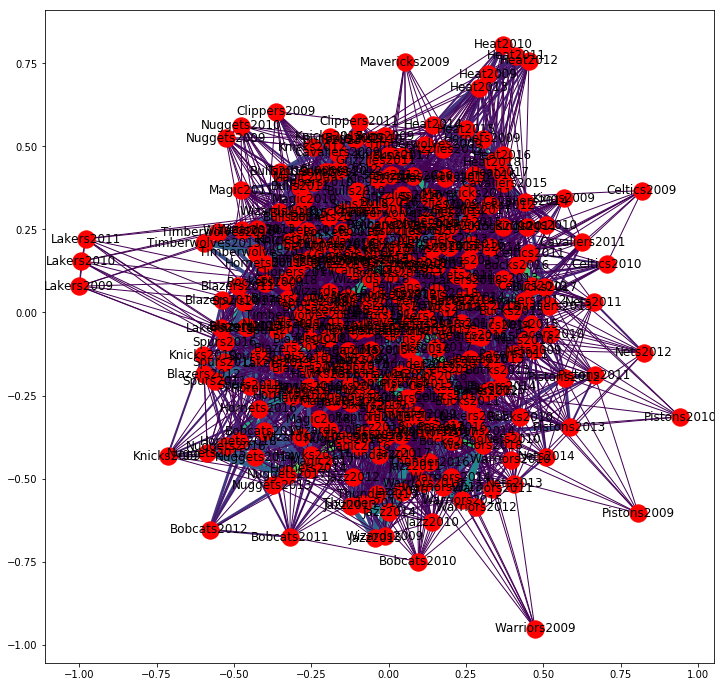

In [32]:
plt.figure(figsize=(12,12))
net.draw_networkx(teamnet, width=team_weights, edge_color=team_weights)

In [33]:
sorted(teamnet.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[:21]

[('Jazz2017', 'Jazz2018', {'weight': 14}),
 ('Celtics2018', 'Celtics2017', {'weight': 12}),
 ('Heat2017', 'Heat2018', {'weight': 12}),
 ('Blazers2018', 'Blazers2017', {'weight': 11}),
 ('Warriors2016', 'Warriors2017', {'weight': 11}),
 ('Nuggets2018', 'Nuggets2017', {'weight': 11}),
 ('Heat2017', 'Heat2016', {'weight': 11}),
 ('Blazers2017', 'Blazers2016', {'weight': 11}),
 ('Raptors2018', 'Raptors2017', {'weight': 11}),
 ('Blazers2015', 'Blazers2016', {'weight': 10}),
 ('Bulls2018', 'Bulls2017', {'weight': 10}),
 ('Hawks2015', 'Hawks2014', {'weight': 10}),
 ('Knicks2017', 'Knicks2018', {'weight': 10}),
 ('Bucks2016', 'Bucks2017', {'weight': 10}),
 ('Warriors2017', 'Warriors2018', {'weight': 10}),
 ('Heat2018', 'Heat2016', {'weight': 10}),
 ('Mavericks2017', 'Mavericks2018', {'weight': 10}),
 ('Raptors2015', 'Raptors2016', {'weight': 10}),
 ('Pacers2017', 'Pacers2018', {'weight': 10}),
 ('Blazers2013', 'Blazers2014', {'weight': 9}),
 ('Hornets2018', 'Hornets2017', {'weight': 9})]

In [34]:
def trim_edges_threshold(g, weight=1):
    g2=net.Graph()
    for f, t, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, t, weight=edata['weight'])
    
    return g2

In [37]:
def island_method_threshold(g, iterations=6):
    weights = [edata['weight'] for f, t, edata in g.edges(data=True)]
    
    mn = int(min(weights))
    mx = int(max(weights))
    
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges_threshold(g,threshold)] for threshold in range(mn,mx,step)]

In [38]:
islands_threshold = island_method_threshold(teamnet)

In [39]:
for i in islands_threshold:
    print(i[0], len(i[1]), len(list(net.connected_component_subgraphs(i[1]))))

1 288 3
3 216 41
5 145 46
7 84 36
9 32 14
11 6 3
13 2 1


In [40]:
g_greater_than9 = islands_threshold[4][1]

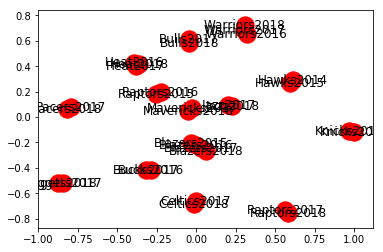

In [41]:
net.draw_networkx(g_greater_than9)

In [42]:
g_greater_than9_subgraphs = net.connected_component_subgraphs(g_greater_than9)

In [43]:
g_greater_than9_subgraphs_all = {}
i=0
for g in g_greater_than9_subgraphs:
    g_greater_than9_subgraphs_all[i] = g
    i = i + 1

In [44]:
g_greater_than9_subgraphs_all

{0: <networkx.classes.graph.Graph at 0x1ad5ea02518>,
 1: <networkx.classes.graph.Graph at 0x1ad5e95e8d0>,
 2: <networkx.classes.graph.Graph at 0x1ad5ea022e8>,
 3: <networkx.classes.graph.Graph at 0x1ad5ea02358>,
 4: <networkx.classes.graph.Graph at 0x1ad5ea024a8>,
 5: <networkx.classes.graph.Graph at 0x1ad5ea46978>,
 6: <networkx.classes.graph.Graph at 0x1ad5ea46940>,
 7: <networkx.classes.graph.Graph at 0x1ad5ea46860>,
 8: <networkx.classes.graph.Graph at 0x1ad5ea46518>,
 9: <networkx.classes.graph.Graph at 0x1ad5ea46710>,
 10: <networkx.classes.graph.Graph at 0x1ad5ea467f0>,
 11: <networkx.classes.graph.Graph at 0x1ad5e239b70>,
 12: <networkx.classes.graph.Graph at 0x1ad5ea6fb70>,
 13: <networkx.classes.graph.Graph at 0x1ad5ea6fd68>}

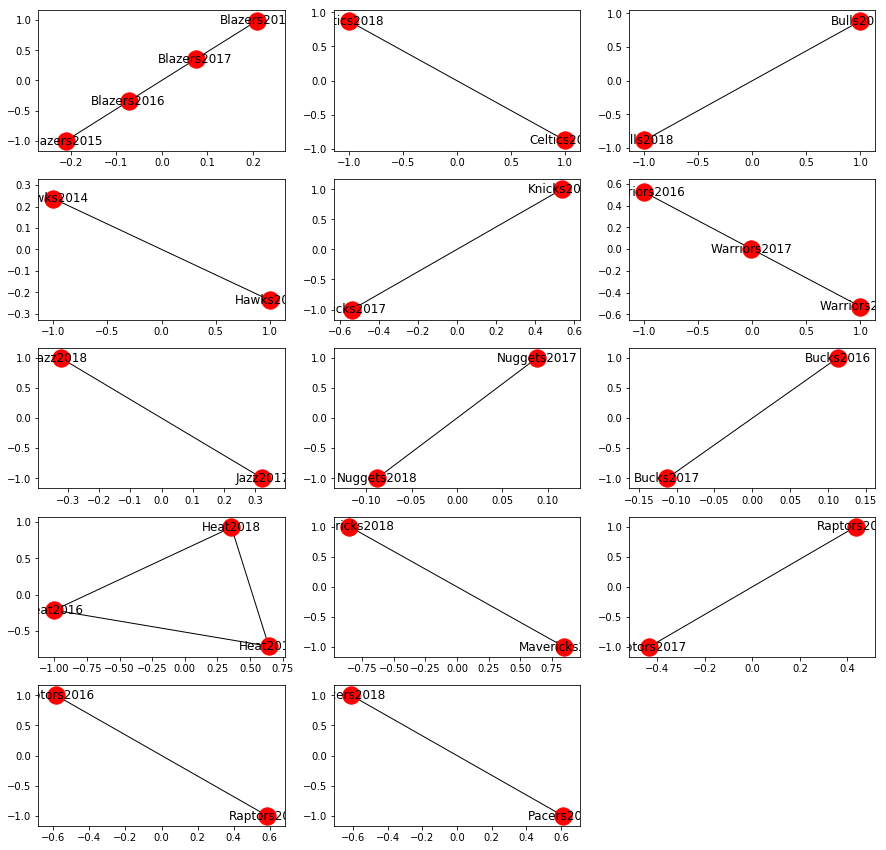

In [45]:
plt.figure(figsize=(15,15))
plt.subplot(5,3,1)
net.draw_networkx(g_greater_than9_subgraphs_all[0])

plt.subplot(5,3,2)
net.draw_networkx(g_greater_than9_subgraphs_all[1])

plt.subplot(5,3,3)
net.draw_networkx(g_greater_than9_subgraphs_all[2])

plt.subplot(5,3,4)
net.draw_networkx(g_greater_than9_subgraphs_all[3])

plt.subplot(5,3,5)
net.draw_networkx(g_greater_than9_subgraphs_all[4])

plt.subplot(5,3,6)
net.draw_networkx(g_greater_than9_subgraphs_all[5])

plt.subplot(5,3,7)
net.draw_networkx(g_greater_than9_subgraphs_all[6])

plt.subplot(5,3,8)
net.draw_networkx(g_greater_than9_subgraphs_all[7])

plt.subplot(5,3,9)
net.draw_networkx(g_greater_than9_subgraphs_all[8])

plt.subplot(5,3,10)
net.draw_networkx(g_greater_than9_subgraphs_all[9])

plt.subplot(5,3,11)
net.draw_networkx(g_greater_than9_subgraphs_all[10])

plt.subplot(5,3,12)
net.draw_networkx(g_greater_than9_subgraphs_all[11])

plt.subplot(5,3,13)
net.draw_networkx(g_greater_than9_subgraphs_all[12])

plt.subplot(5,3,14)
net.draw_networkx(g_greater_than9_subgraphs_all[13])

In [46]:
len(teamnet)

298

In [47]:
min(team_weights)

1

In [48]:
max(team_weights)

14

In [49]:
def trim_edges_below(g, weight=14):
    g2=net.Graph()
    for f, t, edata in g.edges(data=True):
        if edata['weight'] < weight:
            g2.add_edge(f, t, weight=edata['weight'])
    
    return g2

In [50]:
def island_method_below(g, iterations=6):
    weights = [edata['weight'] for f, t, edata in g.edges(data=True)]
    
    mn = int(min(weights))
    mx = int(max(weights))
    
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges_below(g,threshold)] for threshold in range(mn,mx,step)]

In [51]:
islands_below = island_method_below(teamnet)

In [52]:
for i in islands_below:
    print(i[0], len(i[1]), len(list(net.connected_component_subgraphs(i[1]))))

1 0 0
3 298 1
5 298 1
7 298 1
9 298 1
11 298 1
13 298 1


In [54]:
sorted(teamnet.edges(data=True),key= lambda x: x[2]['weight'])[:20]

[('Blazers2013', 'Bulls2017', {'weight': 1}),
 ('Blazers2013', 'Nuggets2018', {'weight': 1}),
 ('Blazers2013', 'Hornets2018', {'weight': 1}),
 ('Blazers2013', 'Jazz2009', {'weight': 1}),
 ('Blazers2013', 'Bulls2016', {'weight': 1}),
 ('Blazers2013', 'Mavericks2018', {'weight': 1}),
 ('Blazers2013', 'Suns2010', {'weight': 1}),
 ('Blazers2013', 'Mavericks2016', {'weight': 1}),
 ('Blazers2013', 'Nuggets2015', {'weight': 1}),
 ('Blazers2013', 'Hornets2016', {'weight': 1}),
 ('Blazers2013', 'Bulls2018', {'weight': 1}),
 ('Blazers2013', 'Spurs2016', {'weight': 1}),
 ('Blazers2013', 'Nuggets2016', {'weight': 1}),
 ('Blazers2013', 'Suns2011', {'weight': 1}),
 ('Blazers2013', 'Spurs2017', {'weight': 1}),
 ('Blazers2013', 'Nuggets2017', {'weight': 1}),
 ('Blazers2013', 'Hornets2017', {'weight': 1}),
 ('Blazers2013', 'Mavericks2015', {'weight': 1}),
 ('Blazers2013', 'Suns2009', {'weight': 1}),
 ('Blazers2013', 'Nets2018', {'weight': 1})]

In [55]:
def trim_edges_between(g, weight_lower=1, weight_upper=16):
    g2=net.Graph()
    for f, t, edata in g.edges(data=True):
        if edata['weight'] <= weight_upper and edata['weight'] >= weight_lower:
            g2.add_edge(f, t, weight=edata['weight'])
    
    return g2

In [56]:
def island_method_below(g, iterations=6):
    weights = [edata['weight'] for f, t, edata in g.edges(data=True)]
    
    mn = int(min(weights))
    mx = int(max(weights))
    
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges_below(g,threshold)] for threshold in range(mn,mx,step)]

islands_below = island_method_below(teamnet)

In [57]:
islands_between_5_and_8 = trim_edges_between(teamnet, 5, 8)

In [58]:
print(len(islands_between_5_and_8), len(list(net.connected_component_subgraphs(islands_between_5_and_8))))

174 44


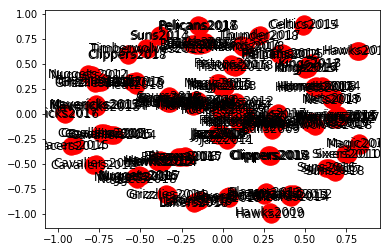

In [59]:
net.draw_networkx(islands_between_5_and_8)

In [60]:
# create an affiliation network of only players
# this will become our main network..
playernet = bi.weighted_projected_graph(g, players)
net.draw(playernet)

KeyError: 'Frank Ntilikina'